# Flight Data Xploration
Jean-Sebastien Gaultier

In [24]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer, OneHotEncoder,  MinMaxScaler, VectorAssembler

## Download the datasets

In [2]:
spark = SparkSession.builder.getOrCreate()

In [4]:
datapath_18 = "gs://msca-bdp-student-gcs/Group4_Final_Project/archive/Combined_Flights_2018.csv"
df_18 = spark.read.csv(datapath_18, header=True, inferSchema=True)

23/11/28 16:09:11 WARN org.apache.spark.scheduler.cluster.YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/11/28 16:09:26 WARN org.apache.spark.scheduler.cluster.YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources


In [5]:
datapath_19 = "gs://msca-bdp-student-gcs/Group4_Final_Project/archive/Combined_Flights_2019.csv"
df_19 = spark.read.csv(datapath_19, header=True, inferSchema=True)

In [6]:
datapath_20 = "gs://msca-bdp-student-gcs/Group4_Final_Project/archive/Combined_Flights_2020.csv"
df_20 = spark.read.csv(datapath_20, header=True, inferSchema=True)

In [7]:
datapath_21 = "gs://msca-bdp-student-gcs/Group4_Final_Project/archive/Combined_Flights_2021.csv"
df_21 = spark.read.csv(datapath_21, header=True, inferSchema=True)

In [8]:
datapath_22 = "gs://msca-bdp-student-gcs/Group4_Final_Project/archive/Combined_Flights_2022.csv"
df_22 = spark.read.csv(datapath_22, header=True, inferSchema=True)

In [10]:
datapath_air = "gs://msca-bdp-student-gcs/Group4_Final_Project/archive/Airlines.csv"
df_airlines = spark.read.csv(datapath_air, header=True, inferSchema=True)

In [11]:
df_all = df_18.union(df_19).union(df_20).union(df_21).union(df_22)

In [12]:
df_18.columns

['FlightDate',
 'Airline',
 'Origin',
 'Dest',
 'Cancelled',
 'Diverted',
 'CRSDepTime',
 'DepTime',
 'DepDelayMinutes',
 'DepDelay',
 'ArrTime',
 'ArrDelayMinutes',
 'AirTime',
 'CRSElapsedTime',
 'ActualElapsedTime',
 'Distance',
 'Year',
 'Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'Marketing_Airline_Network',
 'Operated_or_Branded_Code_Share_Partners',
 'DOT_ID_Marketing_Airline',
 'IATA_Code_Marketing_Airline',
 'Flight_Number_Marketing_Airline',
 'Operating_Airline',
 'DOT_ID_Operating_Airline',
 'IATA_Code_Operating_Airline',
 'Tail_Number',
 'Flight_Number_Operating_Airline',
 'OriginAirportID',
 'OriginAirportSeqID',
 'OriginCityMarketID',
 'OriginCityName',
 'OriginState',
 'OriginStateFips',
 'OriginStateName',
 'OriginWac',
 'DestAirportID',
 'DestAirportSeqID',
 'DestCityMarketID',
 'DestCityName',
 'DestState',
 'DestStateFips',
 'DestStateName',
 'DestWac',
 'DepDel15',
 'DepartureDelayGroups',
 'DepTimeBlk',
 'TaxiOut',
 'WheelsOff',
 'WheelsOn',
 'TaxiIn',
 'CRS

## Visualizing

In [13]:
top_cancelled_tailnumbers = df_all.filter(df_all.Cancelled == True) \
    .groupBy("Tail_Number") \
    .agg(F.count("Tail_Number").alias("CancellationCount")) \
    .orderBy(F.desc("CancellationCount")) \
    .limit(10)

top_cancelled_tailnumbers.show()

+-----------+-----------------+
|Tail_Number|CancellationCount|
+-----------+-----------------+
|     N201JQ|              334|
|     N791SK|              328|
|     N793SK|              322|
|     N783SK|              317|
|     N743SK|              314|
|     N788SK|              311|
|     N779SK|              299|
|     N631RW|              296|
|     N790SK|              294|
|     N785SK|              290|
+-----------+-----------------+



In [14]:
top_avg_delay_tailnumbers = df_all.groupBy("Tail_Number") \
    .agg(F.avg("DepDelay").alias("AvgDepDelay")) \
    .orderBy(F.desc("AvgDepDelay")) \
    .limit(10)

# Display the result or save it to a file or use it in plotting libraries
top_avg_delay_tailnumbers.show()

+-----------+------------------+
|Tail_Number|       AvgDepDelay|
+-----------+------------------+
|     N567NK|             655.0|
|     N654DL|             609.0|
|     N684RW|             491.0|
|     N656YX|             486.0|
|     N416DX|             233.5|
|     N360NK|             223.0|
|      N805H|             213.0|
|     N417DX|              80.0|
|     N863DA|              62.0|
|     N575DZ|53.333333333333336|
+-----------+------------------+



In [15]:
top_flown_tailnumbers = df_all.groupBy("Tail_Number") \
    .agg(F.count("Tail_Number").alias("FlightCount")) \
    .orderBy(F.desc("FlightCount")) \
    .limit(10)

# Display the result or save it to a file or use it in plotting libraries
top_flown_tailnumbers.show()

+-----------+-----------+
|Tail_Number|FlightCount|
+-----------+-----------+
|     N480HA|      12470|
|     N491HA|      12376|
|     N494HA|      12248|
|     N492HA|      11985|
|     N487HA|      11945|
|     N483HA|      11935|
|     N493HA|      11837|
|     N486HA|      11797|
|     N476HA|      11771|
|     N488HA|      11727|
+-----------+-----------+



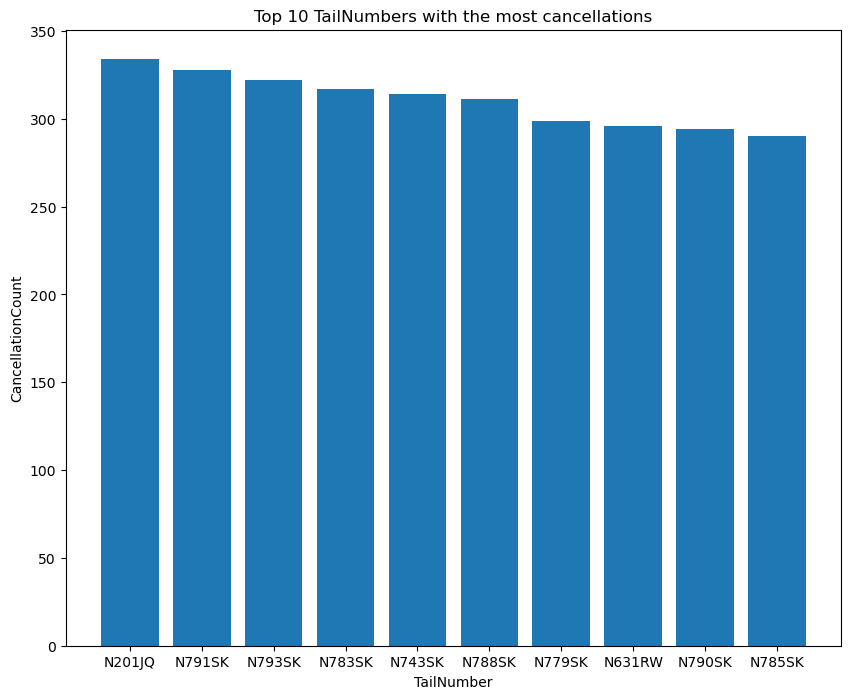

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to Pandas DataFrame
top_cancelled_pd = top_cancelled_tailnumbers.toPandas()

# Plot the data using matplotlib or other plotting libraries
plt.figure(figsize = (10,8))
plt.bar(top_cancelled_pd['Tail_Number'], top_cancelled_pd['CancellationCount'])
plt.xlabel('TailNumber')
plt.ylabel('CancellationCount')
plt.title('Top 10 TailNumbers with the most cancellations')
plt.show()

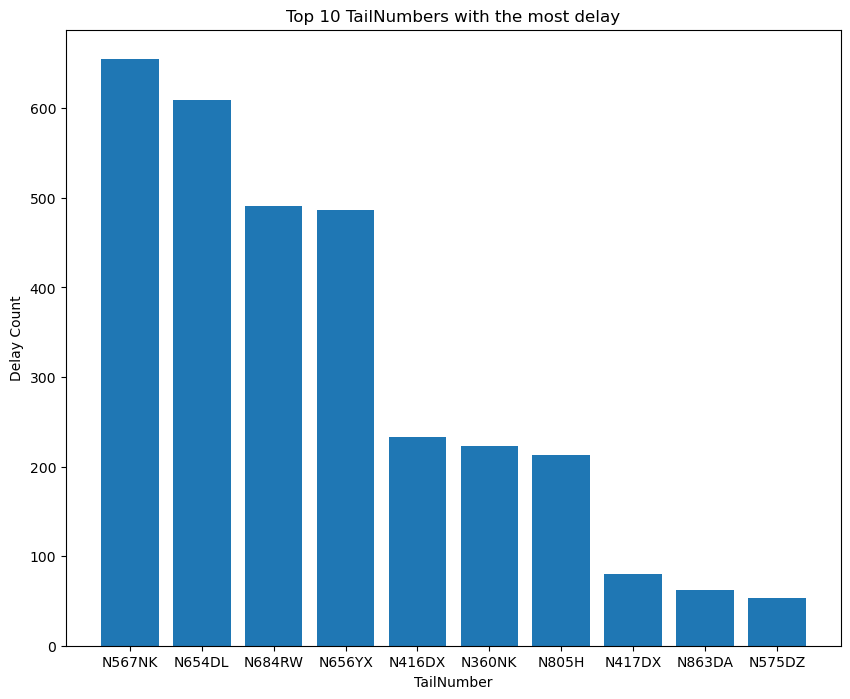

In [17]:

# Convert Spark DataFrame to Pandas DataFrame
top_avg_delay_tailnumbers_pd = top_avg_delay_tailnumbers.toPandas()

# Plot the data using matplotlib or other plotting libraries
plt.figure(figsize = (10,8))
plt.bar(top_avg_delay_tailnumbers_pd['Tail_Number'], top_avg_delay_tailnumbers_pd['AvgDepDelay'])
plt.xlabel('TailNumber')
plt.ylabel('Delay Count')
plt.title('Top 10 TailNumbers with the most delay')
plt.show()

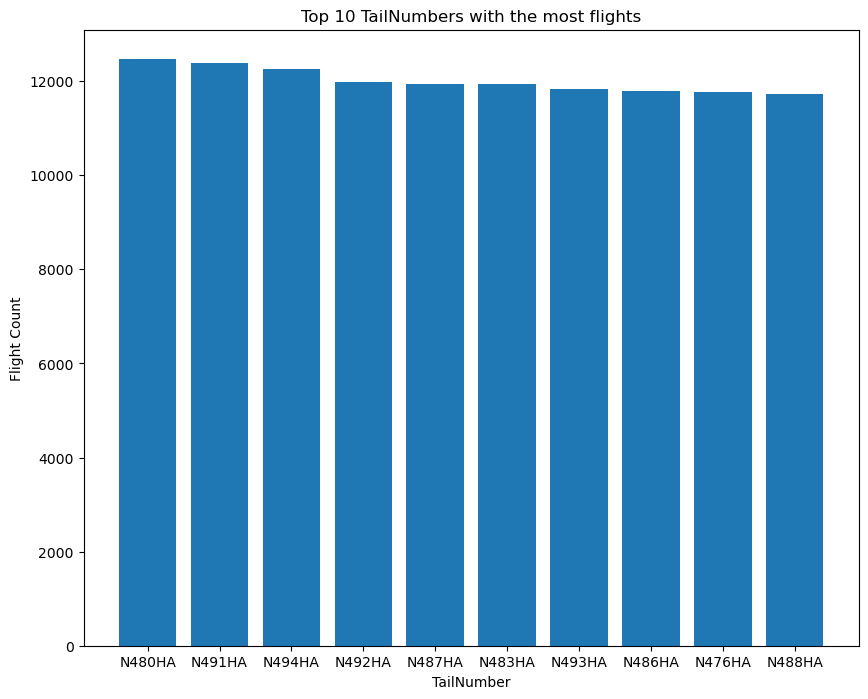

In [18]:
# Convert Spark DataFrame to Pandas DataFrame
top_flown_tailnumbers_pd = top_flown_tailnumbers.toPandas()

# Plot the data using matplotlib or other plotting libraries
plt.figure(figsize = (10,8))
plt.bar(top_flown_tailnumbers_pd['Tail_Number'], top_flown_tailnumbers_pd['FlightCount'])
plt.xlabel('TailNumber')
plt.ylabel('Flight Count')
plt.title('Top 10 TailNumbers with the most flights')
plt.show()

In [25]:
indexer = StringIndexer(inputCol="Tail_Number", outputCol="TailNumberIndex")
flights_indexed = indexer.fit(df_all).transform(df_all)

flights_indexed = flights_indexed.withColumn("Cancelled", flights_indexed["Cancelled"].cast("integer"))
selected_columns = ["DepDelay", "Cancelled", "ArrDelay"]
flights_selected = flights_indexed.select(selected_columns).na.drop()
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
flights_assembled = assembler.transform(flights_selected)

# Calculate correlation matrix
try:
    correlation_matrix = Correlation.corr(flights_assembled, "features").head()

    # Extract the correlation matrix as a NumPy array
    correlation_array = correlation_matrix[0].toArray()

    # Convert correlation matrix to Pandas DataFrame
    correlation_df = pd.DataFrame(correlation_array, columns=selected_columns, index=selected_columns)

    # Use seaborn to create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix Heatmap')
    plt.show()

except Exception as e:
    print(f"Error: {str(e)}")
    # Print more detailed information about the error for troubleshooting
    raise e


Error: name 'sns' is not defined


23/11/28 16:42:26 WARN org.apache.spark.mllib.stat.correlation.PearsonCorrelation: Pearson correlation matrix contains NaN values.


NameError: name 'sns' is not defined

<Figure size 1000x800 with 0 Axes>